# Part 1 - Convolutional Neural Networks for CIFAR-10


In this notebook chapter, we'll build, train and optimize a neural network to classify images of the CIFAR-10 dataset using convolutional neural networks.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.


In [98]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
print(tf.__version__)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer',
               'dogs',      'frogs',   'horses',  'ships',   'trucks']
num_classes = len(class_names)


# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)
print(y_train.shape)
print(y_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

2.7.1
170508288/170498071 [==============================] - 7s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
(50000, 1)
(10000, 1)
(50000, 10)
(10000, 10)


## 1. Preprocess the data

### 1.1 Zero-Centered Images

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be zero-centered to the range. So here we compute the mean value per colour channel over all training images and subtract the mean value per colour channel from every image in the training and test set.

In [99]:
train_mean = X_train.mean(axis=(0,1,2))
train_std =  X_train.std(axis=(0,1,2))
print(train_mean)
X_train_zc = X_train - train_mean
X_test_zc  = X_test - train_mean


print(X_train_zc[3].mean(axis=(0,1)))
print(X_train_zc[3].shape)
print(X_train_zc.shape)
print(X_test_zc.shape)
print(X_train_zc.dtype)

[125.3069  122.95015 113.866  ]
[-25.327402 -39.670845 -56.451923]
(32, 32, 3)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
float32


### 1.2 Data Augmentation

In [100]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


train_datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False, 
        # set each sample mean to 0
        samplewise_center=False,  
        # divide inputs by std of the dataset
        featurewise_std_normalization=False, 
        # divide each input by its std
        samplewise_std_normalization=False,  
        # apply ZCA whitening
        zca_whitening=False, 
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,  
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=0,  
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0., 
        # set range for random zoom
        zoom_range=0.,  
        # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        channel_shift_range=0.,  
        # value used for fill_mode = "constant"
        fill_mode='nearest',
        cval=0.,  
        # randomly flip images
        horizontal_flip=True, 
        # randomly flip images
        vertical_flip=False,  
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

validation_datagen = ImageDataGenerator( 
      # rescale the pixel values (between 0 and 255) to the [0,1] interval 
      # rescale=1./255
)


## 2. Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### 2.1 Define the network

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [101]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train_zc.shape[1:]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('softmax'))

`tf.keras.layers.Conv2D(32, (3, 3)))` implies the following parameter settings:


- `filters` : Integer, the dimensionality of the output space (i.e. the number of output filters in the 
convolution). In this case, the number of filters is $32$.

- `kernel_size` : An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window (receptive field). Can be a single integer to specify the same value for all spatial dimensions. In this 
case, the receptive field of the filters are $3\times3$.

- `strides` : An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Default strides : $(1, 1)$

- `padding`: one of `valid` or `same`. In this case, the size of the output volume won't be changed.

`tf.keras.layers.MaxPooling2D(pool_size=(2, 2))` implies the following parameter settings:

- `pool_size`: integer or tuple of 2 integers, factors by which to downscale (vertical, horizontal). $(2, 2)$ will halve the input in both spatial dimension. If only one integer is specified, the same window length will be used for both dimensions.
- `strides`: Integer, tuple of 2 integers, or `None`. `strides` values. If `None`, it will default to `pool_size`. In this case $(2,2)$.

In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0

### 2.2 Compile and Fit the Network

In [103]:
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Compile Network 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

num_validation_examples = 1000
num_train_examples = 5000


train_iterator = train_datagen.flow(X_train_zc[num_validation_examples:num_train_examples], 
                                    y_train_cat[num_validation_examples:num_train_examples], 
                                    batch_size=32)
validation_iterator = validation_datagen.flow(X_train_zc[:num_validation_examples:], 
                                              y_train_cat[:num_validation_examples:], 
                                              batch_size=32)

# Fit Network
history = model.fit_generator(generator= train_iterator,  
                              validation_data = validation_iterator, 
                              epochs=100, 
                              steps_per_epoch=len(train_iterator),
                              callbacks=[tensorboard_callback])

# Determine 
model.evaluate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
125/125 [==============================] - 65s 496ms/step - loss: 2.2637 - accuracy: 0.1915 - val_loss: 1.9200 - val_accuracy: 0.2960
Epoch 2/100
125/125 [==============================] - 59s 475ms/step - loss: 1.9513 - accuracy: 0.2770 - val_loss: 1.7717 - val_accuracy: 0.3740
Epoch 3/100
125/125 [==============================] - 58s 461ms/step - loss: 1.8561 - accuracy: 0.3145 - val_loss: 1.6933 - val_accuracy: 0.4010
Epoch 4/100
125/125 [==============================] - 60s 482ms/step - loss: 1.7906 - accuracy: 0.3532 - val_loss: 1.6480 - val_accuracy: 0.4350
Epoch 5/100
125/125 [==============================] - 56s 451ms/step - loss: 1.7519 - accuracy: 0.3702 - val_loss: 1.6108 - val_accuracy: 0.4580
Epoch 6/100
125/125 [==============================] - 57s 456ms/step - loss: 1.7103 - accuracy: 0.3938 - val_loss: 1.5763 - val_accuracy: 0.4750
Epoch 7/100
125/125 [==============================] - 57s 453ms/step - loss: 1.6755 - accuracy: 0.4050 - val_loss: 1.5648 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 62/100
125/125 [==============================] - 55s 442ms/step - loss: 1.0842 - accuracy: 0.6538 - val_loss: 1.1262 - val_accuracy: 0.6240
Epoch 63/100
125/125 [==============================] - 56s 447ms/step - loss: 1.1145 - accuracy: 0.6292 - val_loss: 1.0857 - val_accuracy: 0.6260
Epoch 64/100
125/125 [==============================] - 56s 447ms/step - loss: 1.1011 - accuracy: 0.6392 - val_loss: 1.1256 - val_accuracy: 0.6110
Epoch 65/100
125/125 [==============================] - 56s 445ms/step - loss: 1.0765 - accuracy: 0.6565 - val_loss: 1.0557 - val_accuracy: 0.6370
Epoch 66/100
125/125 [==============================] - 56s 445ms/step - loss: 1.0834 - accuracy: 0.6450 - val_loss: 1.1164 - val_accuracy: 0.6160
Epoch 67/100
125/125 [==============================] - 55s 442ms/step - loss: 1.0699 - accuracy: 0.6575 - val_loss: 1.0950 - val_accuracy: 0.6170
Epoch 68/100
125/125 [==============================] - 56s 450ms/step - loss: 1.0688 - accuracy: 0.6615 - val_loss: 1

<bound method Model.evaluate of <keras.engine.sequential.Sequential object at 0x7ff455bf7410>>

### 2.3 Evaluate the Network on the test dataset

In [104]:
model.evaluate(X_test_zc, y_test_cat)

313/313 [==============================] - 30s 95ms/step - loss: 1.0085 - accuracy: 0.6609


[1.0084725618362427, 0.6608999967575073]

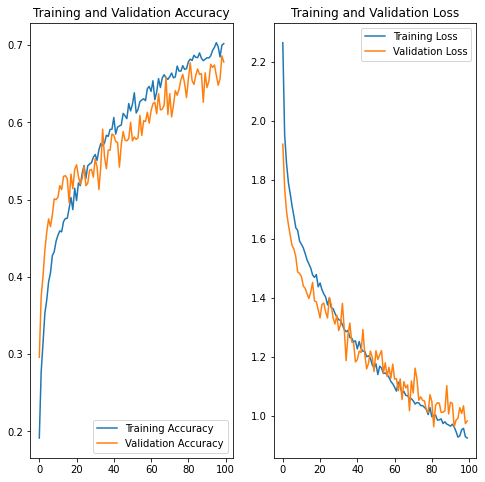

In [105]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [107]:
os.makedirs(logdir, exist_ok=True)
%tensorboard --logdir logs


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/opt/conda/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 23, in <module>
    from tensorboard import plugin_util
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/plugin_util.py", line 24, in <module>
    import markdown
  File "/opt/conda/lib/python3.7/site-packages/markdown/__init__.py", line 29, in <module>
    from .core import Markdown, markdown, markdownFromFile  # noqa: E402
  File "/opt/conda/lib/python3.7/site-packages/markdown/core.py", line 26, in <module>

### Save the model

In [108]:
model.save('./Daten/cifar_10_convnets_1.h5')

# Part 2 - Dogs vs Cats Image Classification : Visualizing what ConvNets learn?

In this notebook chapter, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. At the end, we will visualize filters and intermediate activation layers.

### Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class — How can we efficiently work with data on disk to interface with our model?
* _Overfitting_ - what is it, how to identify it, and how can we prevent it?
* _Data Augmentation_ and _Dropout_ - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.
* _Visualizing ConvNet filters_
* _Visualizing intermediate activations_


### We will follow the general machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process

<hr>




### Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [109]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

In [110]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In this Jupyter Notebook however, we will make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to your computers filesystem.

In [111]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68616192/68606236 [==============================] - 0s 0us/step


The dataset we have downloaded has following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We'll now assign variables with the proper file path for the training and validation sets.

In [112]:
print(os.path.dirname(zip_dir))
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
print(base_dir)
train_dir = os.path.join(base_dir, 'train')
print(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
print(validation_dir)

/home/jovyan/.keras/datasets
/home/jovyan/.keras/datasets/cats_and_dogs_filtered
/home/jovyan/.keras/datasets/cats_and_dogs_filtered/train
/home/jovyan/.keras/datasets/cats_and_dogs_filtered/validation


In [113]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
print(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
print(train_dogs_dir)
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
print(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
print(validation_dogs_dir)

/home/jovyan/.keras/datasets/cats_and_dogs_filtered/train/cats
/home/jovyan/.keras/datasets/cats_and_dogs_filtered/train/dogs
/home/jovyan/.keras/datasets/cats_and_dogs_filtered/validation/cats
/home/jovyan/.keras/datasets/cats_and_dogs_filtered/validation/dogs


### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [114]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [115]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### Setting Model Parameters

For convenience, let us set up variables that will be used later while pre-processing our dataset and training our network.

In [116]:
BATCH_SIZE = 128
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

After defining our generators for training and validation images, `flow_from_directory` method will load images from the disk and will apply rescaling and will resize them into required dimensions using single line of code.

## 2.1 Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In `tf.keras` we can implement this using the same `ImageDataGenerator` class we used in the last teaching unit. We can simply pass different transformations we want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [117]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### 2.1.1 Flipping the image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [118]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


from `IPython.display` import `display`, `ImageTo` see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

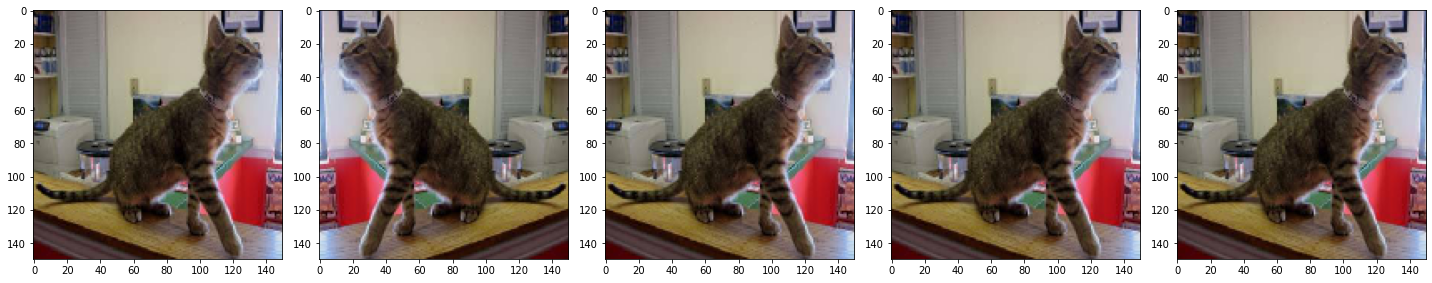

In [119]:
from PIL import Image
# if not installed, execute !pip3 install pillow
# then restart kernel
import PIL.Image
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 2.1.2 Rotating the image

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [120]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

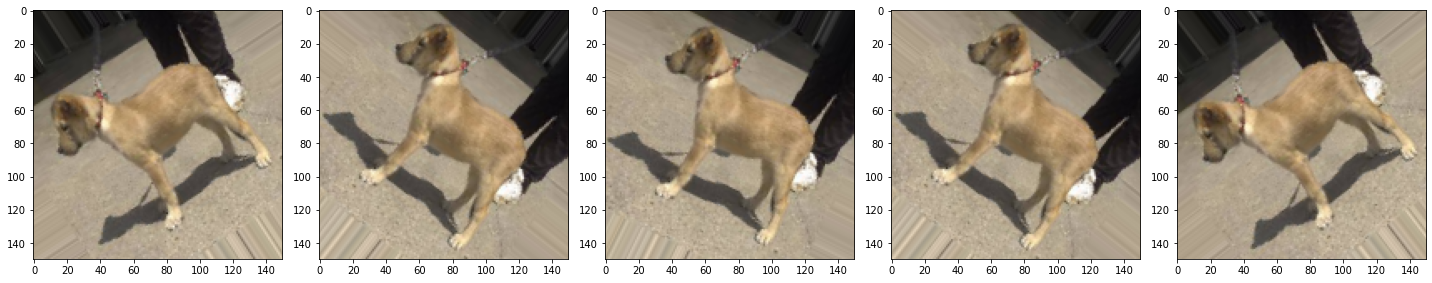

In [121]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 2.1.3 Applying Zoom

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [122]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 2000 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

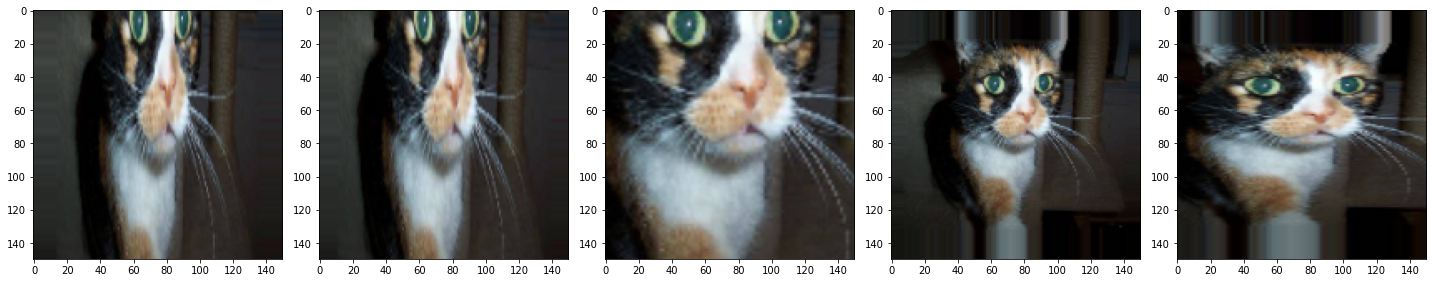

In [123]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 2.1.4 Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [124]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

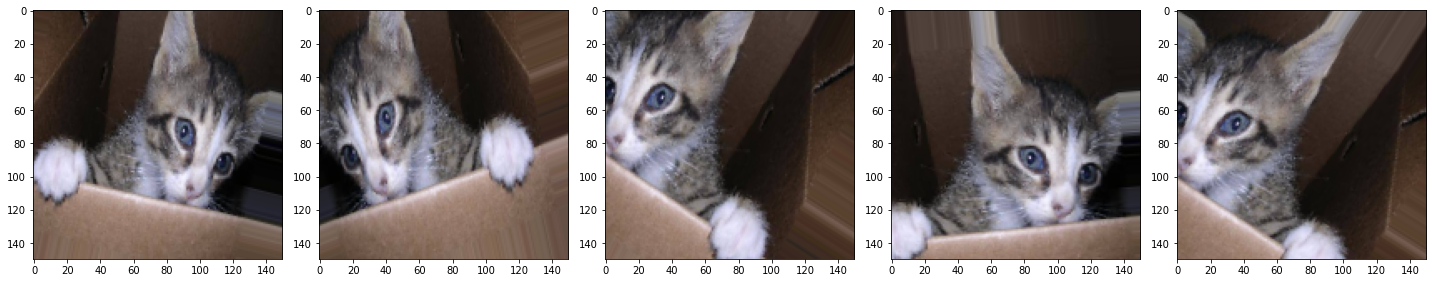

In [125]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 2.1.5 Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [126]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## 2.2 Model Creation

### 2.2.1 Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [127]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

### 2.2.2 Compiling the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [128]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 2.2.3 Model Summary

Let's look at all the layers of our network using `summary` method.

In [129]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 128)     

### 2.2.4 Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [ ]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100


### 2.2.5 Visualizing results of the training

We'll now visualize the results we get after training our network.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2.2.6 Saving the model

In [ ]:
model.save('./Daten/cats_and_dogs_small_1.h5')

# Part 2 - Using a Pretrained ConvNet Model

A common and highly effective approach to deep learning on small image datasets is
to use a pretrained model. A _pretrained model_ is a model that was previously trained on
a large dataset, typically on a large-scale image-classification task. If this original dataset
is large enough and general enough, the spatial hierarchy of features learned by
the pretrained model can effectively act as a generic model of the visual world, and
hence, its features can prove useful for many different computer vision problems,
even though these new problems may involve completely different classes than those
of the original task. For instance, you might train a model on ImageNet (where classes
are mostly animals and everyday objects) and then repurpose this trained model for
something as remote as identifying furniture items in images. Such portability of
learned features across different problems is a key advantage of deep learning compared
to many older, shallow learning approaches, and it makes deep learning very
effective for small-data problems.


In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4
million labeled images and 1'000 different classes). ImageNet contains many animal
classes, including different species of cats and dogs, and you can thus expect it to perform well on the dogs-versus-cats classification problem.

We’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew
Zisserman in 2014. Although it’s an older model, far from the current state of the art
and somewhat heavier than many other recent models, we chose it because its architecture
is similar to what you’re already familiar with, and it’s easy to understand without
introducing any new concepts. This may be your first encounter with one of these
cutesy model names — VGG, ResNet, Inception, Xception, and so on; you’ll get used
to them because they will come up frequently if you keep doing deep learning for
computer vision.



In [ ]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
print(tf.__version__)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Defining the loss tensor for filter visualization

model_vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                   include_top=True)

### 2.1 Instantiating the VGG16 Architecture

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                   include_top=True)

We pass two arguments to the constructor:

- `weights` specifies the weight checkpoint from which to initialize the model.

- `include_top` refers to including (or not) the densely connected classifier on
top of the network. By default, this densely connected classifier corresponds to
the 1'000 classes from ImageNet. Because we intend to use the entire pretrained VGG16 network, we will include it.

In [ ]:
model_vgg16.summary()

### 2.2 Run VGG16 on a single image

Remember our `model_vgg16` object is still the full VGG16 model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

Next, we we'll get an input image -- a picture of a cat, not part of the images 
the network was trained on. 

#### 2.2.1 Preprocessing a single image

In [ ]:
import numpy as np
import PIL.Image as Image

img_path = './Daten/cat_1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

def get_img_array(img_path, target_size):
    # Open the image file and resize it
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    # Turn the image into a float32 NumPy array of shape (224, 224, 3)
    array = tf.keras.utils.img_to_array(img)
    # Add a dimension to transform the array into 
    # a “batch” of a single sample. 
    # Its shape is now (1, 224, 224, 3).
    array = np.expand_dims(array, axis=0)
    return array


img_tensor_orig = get_img_array(img_path, target_size=(224, 224))

img_tensor =img_tensor_orig/255

print(img_tensor.shape)


#### 2.2.2 Displaying the test picture

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
result = model_vgg16.predict(img_tensor_orig)
result.shape

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a cat or something else?

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

#### 2.2.3 Decode the predictions

To see what our `predicted_class` is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

In [ ]:
print(tf.keras.applications.vgg16.decode_predictions(result, top=3))

plt.imshow(img_tensor[0])
plt.axis('off')
predicted_class_name = tf.keras.applications.vgg16.decode_predictions(result, top=1)[0][0][1]
_ = plt.title("Prediction: " + predicted_class_name)

That is not correct. Let us see, whether we can do it better with our model we have trained 
before.

### 2.3 Running single image with model trained entirely on dog and cat image dataset

#### 2.3.1 Preprocessing a single image

In [ ]:
model = tf.keras.models.load_model('./Daten/cats_and_dogs_small_1.h5', compile = False)
model.summary()

We first need to resize the photo of the cat to the size $150\times 150$.

In [ ]:
img_path = './Daten/cat_1700.jpg'

img_tensor_orig = get_img_array(img_path, target_size=(150, 150))

img_tensor =img_tensor_orig/255

print(img_tensor.shape)

#### 2.3.2 Decode the predictions

In [ ]:
result = model.predict(img_tensor)
print(result)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

The subdirectory “cat” comes before “dog“, therefore the class labels are assigned the integers: _cat=0, dog=1_. Thus, the prediction is correct.

# Part 3 - Visualizing what ConvNets Learn


A fundamental problem when building a computer vision application is that of _interpretability_: why did your classifier think a particular image contained a fridge, when all you can see is a truck? This is especially relevant to use cases where deep learning is used to complement human expertise, such as in medical imaging use cases. We will end this chapter by getting you familiar with a range of different techniques for visualizing
what convnets learn and understanding the decisions they make.


It’s often said that deep learning models are “black boxes”: they learn representations
that are difficult to extract and present in a human-readable form. Although this
is partially true for certain types of deep learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re _representations of visual concepts_. Since 2013, a wide array of techniques has been developed for visualizing and interpreting these representations. We won’t survey all of them, but we’ll cover three of the most accessible
and useful ones:

- _Visualizing intermediate ConvNet outputs (intermediate activations)_ -- Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual ConvNet filters.

- _Visualizing ConvNet filters_ -- Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to. 

- _Visualizing heatmaps of class activation in an image_ -- Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

For the first method - activation visualization - we will use the small ConvNet that we have trained from scratch on the dogs-versus-cats classification problem before. For the last method, we’ll use a pretrained Xception model.

## 3.1 Visualizing Intermediate Layers


Visualizing intermediate activations consists of displaying the values returned by various convolution and pooling layers in a model, given a certain input (the output of a layer is often called its __activation__, the output of the activation function). 

This gives a view into how an input is decomposed into the different filters learned by the network. We want to visualize feature maps with three dimensions: width, height, and depth (number of filters = number of activation maps).
Each filter encodes relatively independent features, so the proper way to visualize
these feature maps is by independently plotting the contents of every activation map as a 2D image. Let’s start by loading the model that we trained on the cats-vs-dogs dataset. 

In [3]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
print(tf.__version__)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

model = tf.keras.models.load_model('./Daten/cats_and_dogs_small_1.h5')
model.summary()

2.7.1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 128

Next, we we'll get an input image -- a picture of a cat, not part of the images 
the network was trained on. 

In [4]:
from tensorflow import keras
import numpy as np

# Download a test image
img_path = keras.utils.get_file(fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
# Alternatively, use the following one
#img_path = './Daten/cat_1700.jpg'

def get_img_array(img_path, target_size):
    # Open the image file and resize it.
    img = keras.utils.load_img(img_path, target_size=target_size)
    # Turn the image into a float32 NumPy array of shape (150, 150, 3)
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into
    # a “batch” of a single sample. Its shape is now
    # (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array


img_tensor = get_img_array(img_path, target_size=(150, 150))


print(img_tensor.shape)

(1, 150, 150, 3)


#### Displaying the test picture

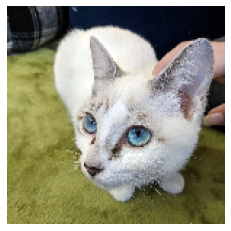

In [5]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In order to extract the activation maps we want to look at, we’ll create a Keras model that takes batches of images as input, and that outputs the activations of all convolution and pooling layers.

#### Instantiating a model that returns layer activations

In [6]:
from tensorflow.keras import layers
layer_outputs = []
layer_names = []
for layer in model.layers:
    # Extract the outputs of all Conv2D and MaxPooling2D layers and put them in a list.
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        # Save the layer names for later
        layer_names.append(layer.name)
# Create a model that will return these outputs, given the model input.        
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the
original model, as a list. This is a multi-output model. Until now,
the models we’ve seen have had exactly one input and one output. This one has one
input and eight outputs: one output per layer activation.

#### Using the model to compute layer activations

In [7]:
# Return a list of nine NumPy arrays: one array per layer activation.
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for the cat image input:

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It’s a $148\times 148$ feature map with 32 channels. Let’s try plotting the fifth channel of the activation of the first layer of the original model

#### Visualizing the fifth channel

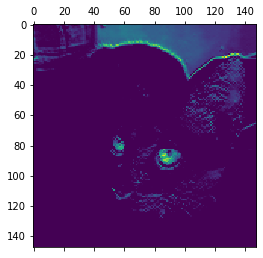

In [9]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

This channel appears to encode a diagonal edge detector—but note that your own
channels may vary, because the specific filters learned by convolution layers aren’t
deterministic.
Now, let’s plot a complete visualization of all the activations in the network. We’ll extract and plot every channel in each of the layer activations, and
we’ll stack the results in one big grid, with channels stacked side by side.

#### Visualizing every channel in every intermediate activation

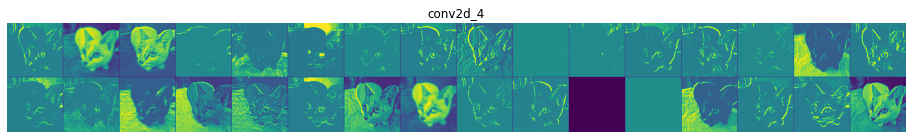

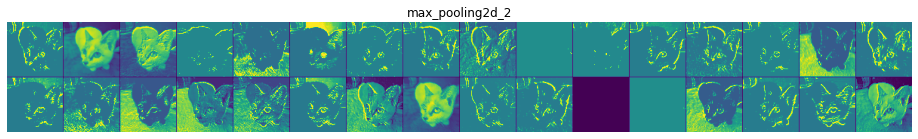

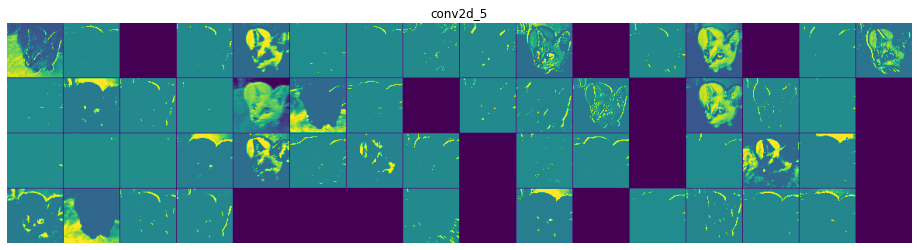

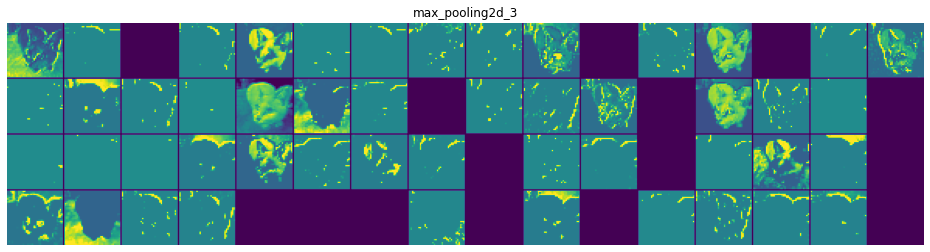

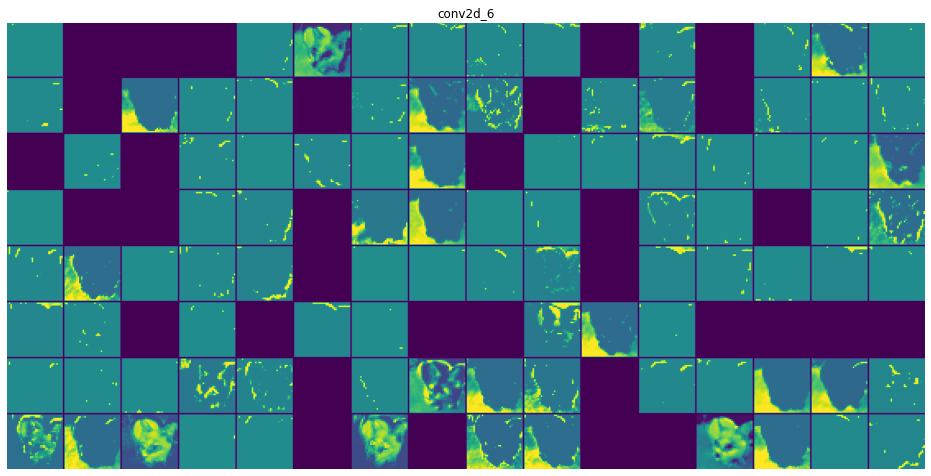

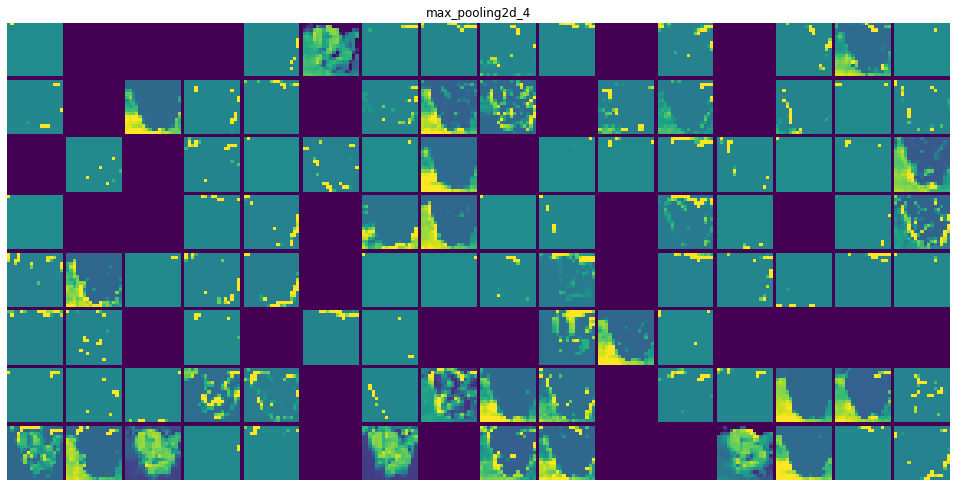

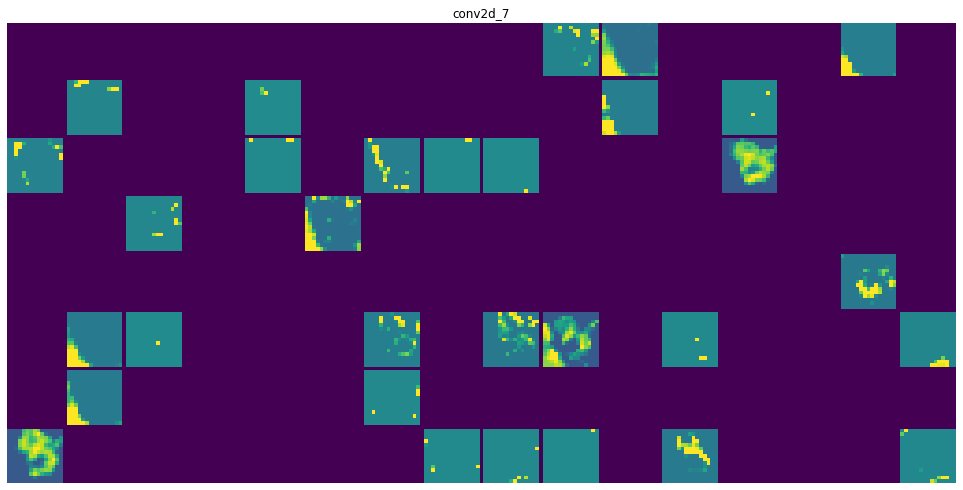

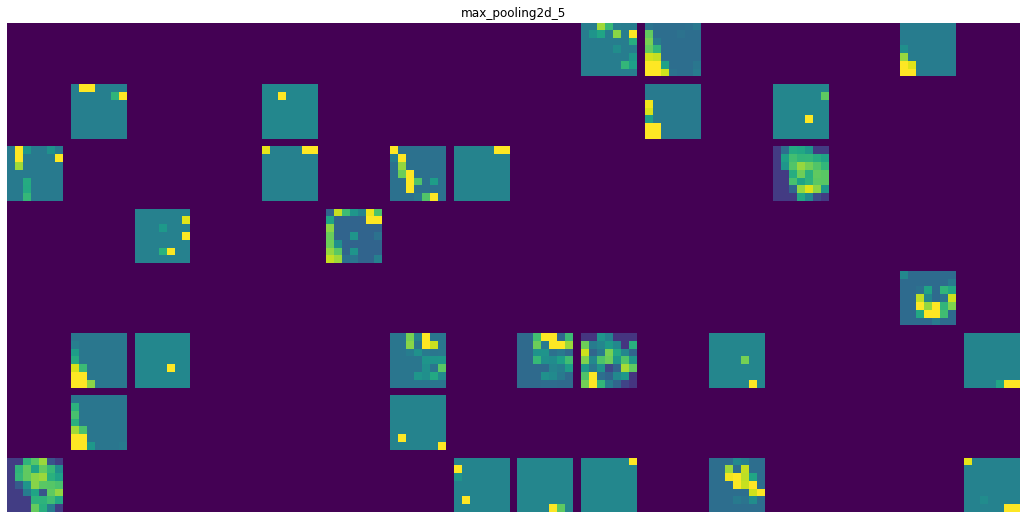

In [10]:
images_per_row = 16
# Iterate over the activations (and the names of the corresponding layers)
for layer_name, layer_activation in zip(layer_names, activations):
    # The layer activation has shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    # Prepare an empty grid for displaying all the channels in this activation.
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            # This is a single channel (or feature)
            channel_image = layer_activation[0, :, :, channel_index].copy()
            # Normalize channel values within the [0, 255] range. Allzero
            # channels are kept at zero.
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            # Place the channel matrix in the empty grid we prepared.
            display_grid[col * (size + 1): (col + 1) * size + col, row * (size + 1) : (row + 1) * size + row] = channel_image

    # Display the grid for the layer.
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

There are a few things to note here:

- The first layer acts as a collection of various edge detectors. At that stage, the
  activations retain almost all of the information present in the initial picture.

- As you go deeper, the activations become increasingly abstract and less visually
  interpretable. They begin to encode higher-level concepts such as “cat ear” and
  “cat eye.” Deeper presentations carry increasingly less information about the
  visual contents of the image, and increasingly more information related to the
  class of the image.

- The sparsity of the activations increases with the depth of the layer: in the first
  layer, almost all filters are activated by the input image, but in the following   
  layers, more and more filters are blank. This means the pattern encoded by the filter
  isn’t found in the input image.


We have just evidenced an important universal characteristic of the representations
learned by deep neural networks: the features extracted by a layer become increasingly
abstract with the depth of the layer. The activations of higher layers carry less
and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog). A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and useful information is magnified and refined (for example, the class of the image).

This is analogous to the way humans and animals perceive the world: after observing
a scene for a few seconds, a human can remember which abstract objects were
present in it (bicycle, tree) but can’t remember the specific appearance of these
objects. In fact, if you tried to draw a generic bicycle from memory, chances are you
couldn’t get it even remotely right, even though you’ve seen thousands of bicycles in
your lifetime. Try it right now: this effect is absolutely real. Your brain has learned to completely abstract its visual input—to transform it into high-level visual concepts while filtering out irrelevant visual details—making it tremendously difficult to remember how things around you look.

## 3.2 Visualizing Convnet Filters

We can access all of the layers of the model via the `model.layers` property.

Each layer has a `layer.name` property, where the convolutional layers have a naming convolution like `block#_conv#`, where the `#` is an integer. Therefore, we can check the name of each layer and skip any that don’t contain the string `conv`.

In [11]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue

Each convolutional layer has two sets of weights. One is the block of filters and the other is the block of bias values. These are accessible via the `layer.get_weights()` function. We can retrieve these weights and then summarize their shape.

In [12]:
# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)

dense_3 (512, 2)


Tying this together, the complete example of summarizing the model filters is listed below.

In [13]:
# summarize filters in each convolutional layer
import matplotlib.pyplot as plt
# load the model

# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_4 (3, 3, 3, 32)
conv2d_5 (3, 3, 32, 64)
conv2d_6 (3, 3, 64, 128)
conv2d_7 (3, 3, 128, 128)


We can see that all convolutional layers use 3×3 filters, which are small and perhaps easy to interpret.

We can retrieve the filters from the first layer as follows:

In [14]:
# retrieve weights from the first hidden layer
filters, biases = model.layers[0].get_weights()
print(filters.shape, biases.shape, filters.dtype)

(3, 3, 3, 32) (32,) float32


In [15]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

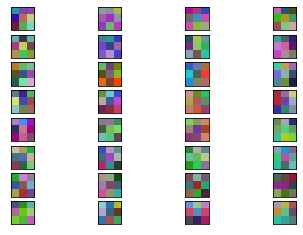

In [16]:
# plot all 32 filters
n_filters = 32
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    ax = plt.subplot(8, 4 , i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f)
# show the figure
plt.show()

We can see that for the input image with three channels for red, green and blue, that each filter has a depth of three (here we are working with a channel-last format). We could visualize one filter as a plot with three images, one for each channel, or compress all three down to a single color image, or even just look at the first channel and assume the other channels will look the same. The problem is, we then have 63 other filters that we might like to visualize.


Now we can enumerate the first six filters out of the 32 in the block and plot each of the three channels of each filter.

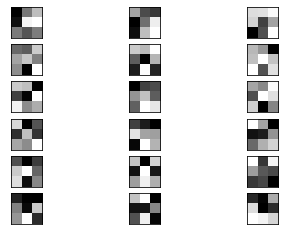

In [17]:
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

## 3.3 Visualizing heatmaps of class activation in an image_

We’ll introduce one last visualization technique — one that is useful for understanding
which parts of a given image led a convnet to its final classification decision. This is
helpful for “debugging” the decision process of a convnet, particularly in the case of a
classification mistake (a problem domain called _model interpretability_). It can also allow you to locate specific objects in an image.

This general category of techniques is called _class activation map_ (CAM) visualization,
and it consists of producing heatmaps of class activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class,
computed for every location in any input image, indicating how important each location
is with respect to the class under consideration. For instance, given an image fed
into a dogs-versus-cats convnet, CAM visualization would allow you to generate a heatmap
for the class “cat,” indicating how cat-like different parts of the image are, and
also a heatmap for the class “dog,” indicating how dog-like parts of the image are.
The specific implementation we’ll use is the one described in an article titled “Grad-
CAM: Visual Explanations from Deep Networks via Gradient-based Localization.”

Grad-CAM consists of taking the output volume of a convolution layer, given
an input image, and weighting every activation map by the gradient of
the class with respect to the activation map. Intuitively, one way to understand this trick is to imagine that you’re weighting an activation map of “how intensely the input image activates this activation map” by “how important each activation map is with regard to the class,” resulting in a spatial map of “how intensely the input image activates the class.”

Let’s demonstrate this technique using the pretrained Xception model.

#### Loading the Xception network with pretrained weights

In [19]:
# Note that we include the densely connected classifier on top
model = keras.applications.xception.Xception(weights="imagenet")

Consider the image of two African elephants shown in the figure below, possibly a mother
and her calf, strolling on the savanna. Let’s convert this image into something the Xception model can read: the model was trained on images of size $299\times 299$, preprocessed according to a few rules that are packaged in the `keras.applications.xception.preprocess_input` utility function. So we need to load the image, resize it to $299\times 299$, convert it to a NumPy float32 tensor, and apply these preprocessing rules.

#### Preprocessing an input image for Xception

In [20]:
# Download the image and store it locally under the path img_path
img_path = keras.utils.get_file(fname="elephant.jpg", origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    # Return a Python Imaging Library (PIL) image of size 299   299
    img = keras.utils.load_img(img_path, target_size=target_size)
    # Return a float32 NumPy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into a batch of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    # Preprocess the batch (this does channel-wise color normalization).
    array = keras.applications.xception.preprocess_input(array)
    return array
img_array = get_img_array(img_path, target_size=(299, 299))

We can now run the pretrained network on the image and decode its prediction vector
back to a human-readable format:

In [21]:
preds = model.predict(img_array)

In [22]:
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

[('n02504458', 'African_elephant', 0.8699273), ('n01871265', 'tusker', 0.07696827), ('n02504013', 'Indian_elephant', 0.023537142)]


The top three classes predicted for this image are as follows:

 - _African elephant_ (with 87% probability)
 
 - _Tusker_ (with 7% probability)
 
 - _Indian elephant_ (with 2% probability)

The network has recognized the image as containing an undetermined quantity of
African elephants. The entry in the prediction vector that was maximally activated is
the one corresponding to the “African elephant” class, at index 386:

In [23]:
np.argmax(preds[0])

386

To visualize which parts of the image are the most African-elephant–like, let’s set up
the Grad-CAM process. First, we create a model that maps the input image to the activations of the last convolutional layer.

#### Setting up a model that returns the last convolutional output

In [24]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = ["avg_pool", "predictions",]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

Second, we create a model that maps the activations of the last convolutional layer to
the final class predictions.

#### Reapplying the classifier on top of the last convolutional output

In [25]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Then we compute the gradient of the top predicted class for our input image with
respect to the activations of the last convolution layer.

#### Retrieving the gradients of the top predicted class

In [ ]:
import tensorflow as tf
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Retrieve the activation map corresponding to the top predicted class
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
# This is the gradient of the top predicted class with regard
# to the output feature map of the last convolutional layer    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

Now we apply pooling and importance weighting to the gradient tensor to obtain our
heatmap of class activation.

#### Gradient pooling and channel-importance weighting

In [ ]:
# This is a vector where each entry is the mean intensity of the
# gradient for a given channel. It quantifies the importance of
# each channel with regard to the top predicted class
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    # Multiply each channel in the output of the last
    # convolutional layer by “how important this activation map is"
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
# The channel-wise mean of the resulting feature 
# map is our heatmap of class activation.    
heatmap = np.mean(last_conv_layer_output, axis=-1)

For visualization purposes, we’ll also normalize the heatmap between 0 and 1.

#### Heatmap post-processing

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Finally, let’s generate an image that superimposes the original image on the heatmap
we just obtained

#### Superimposing the heatmap on the original picture

In [ ]:
import matplotlib.cm as cm
# Load the original image.
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

In [ ]:
# Rescale the heatmap to the range 0–255
heatmap = np.uint8(255 * heatmap)

# Use the "jet" colormap to recolorize the heatmap
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]

# Create an image that contains the recolorized heatmap
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# Superimpose the heatmap and the original image,
# with the heatmap at 40% opacity.
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

This visualization technique answers two important questions:

 - Why did the network think this image contained an African elephant?
 
 - Where is the African elephant located in the picture?
 
In particular, it’s interesting to note that the ears of the elephant calf are strongly activated:
this is probably how the network can tell the difference between African and
Indian elephants.